In [22]:
from qiskit import *
from numpy.random import randint, shuffle
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
%run BB84_functions.ipynb
%run LDPC_functionsMD.ipynb

In [75]:
def QCC(qubits, x) :
    random_errors = randint(0, N, x)
    print(random_errors)
    for i in range(x) :
        random_gate = randint(2)
        print(random_gate)
        if random_gate == 0:
            qubits.x([random_errors[i]])
        else :
            qubits.h([random_errors[i]])
    return qubits

In [76]:
def CAC(bits) :
    return bits

In [105]:
n = 25
N = 100
noise = 2

In [106]:
#Step 1 - Ram generates bits
ram_bits = bit_string(N)
print(ram_bits)

#Step 2 - Ram generates the bases string
ram_bases = bit_string(N)
print(ram_bases)

#Step 3 - Sita generates the bases string
sita_bases = bit_string(N)
print(sita_bases)

[1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0
 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1
 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1]
[1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0
 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0]
[0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0
 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1
 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0]


|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Dev's bits|Y|N|N|
|Dev's bases|Y|N|N|
|Abhi's bases|N|Y|N|

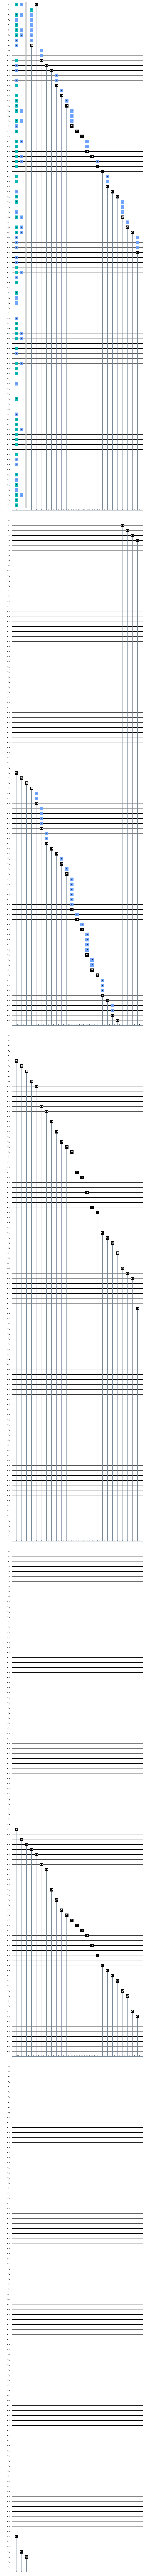

In [107]:
#Step 4 - Ram encodes his bits in the chosen bases 
ram_encode = encode_bits(ram_bits, ram_bases)

#Step 5 - Ram sends his encoded bits to Sita and Ravan tries to intercept over the Quantum channel
received_encode = ram_encode
received_encode.x(1)

#Step 6 - Sita measures Ram's bits in the chosen bases
sita_circuit, sita_bits = measure_bits(received_encode, sita_bases)

#Step 7 - Sita announces that she has received the encoding and measured it over CAC

#Step 8 - Ram and Sita exchange their bases over CAC
r2s = CAC(ram_bases)
s2r = CAC(sita_bases)

#Step 9 - Ram and Sita discard all the bits that correspond to disagreed bases
agreed_base_indices = agreed_bases(ram_bases, sita_bases)
sita_circuit.draw(output = 'mpl')

|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Dev's Encoding|Y|Partial|Noisy|
|Abhi's bits|N|N|Y|
|Dev's and Abhi's bases|Y|Y|Y|

In [108]:
#Step 10 - Error rate checking 
S2T = bit_string(len(agreed_base_indices))
T = select_bits(agreed_base_indices, S2T, 0)
T.append(1)
print(len(T))

#Step 11 - Ram tells T to Sita over CAC
sita_T = CAC(T)

#Step 12 - Ram and Sita generate their test bits 
ram_test_bits, sita_test_bits = [], []
for i in T :
    ram_test_bits.append(ram_bits[i])
    sita_test_bits.append(sita_bits[i])

#Step 12 - Ram and Sita announce their test bits to each other over the CAC

#Step 13 - Ram and Sita compute the error rate
error = error_rate(ram_test_bits, sita_test_bits)
print(error)

23
0.08695652173913043


|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|T|Y|Y|Y|
|Dev's test bits|Y|Y|Y|
|Abhi's test bits|Y|Y|Y|

In [109]:
#Step 14 - Ram and Sita check over a threshold for error before proceeding ahead
if error > 0.11 :
    print ("Abort")
else :
    #Step 15 - Ram and Sita generate their pseudo keys
    SminusT = select_bits(agreed_base_indices, S2T, 1)
    ram_pseudokey, sita_pseudokey = [], []
    for i in SminusT :
        ram_pseudokey.append(ram_bits[i])
        sita_pseudokey.append(sita_bits[i])

    #Step 16 - LDPC reconciliation
    #SubStep1 : Produce parity check matrix(M1) of dimension m*n, n is length of bitstring and m is no. of parity check equations
    H = parity_matrix(m, n)
    k = non_zeros(H)

    #SubStep2 : Ram produces the syndrome and hash values
    C = syndrome(H, ram_bits)

    #Step3 : Ram sends syndrome via CAC

    #Step4 : Sita produces the syndrome
    D = syndrome(H, sita_bits)

    #Step5 : Ram performs belief propagation algorithm
    y1, success = belief_prop(C, D, MAX_ITERS, p, k, sita_bits, H)

    #Step6 : Sita sends success of reconciliation
    corrected_bits = sum([y1[i] ^ sita_bits[i] for i in range(len(sita_bits))])
    corrected_QBER = 
    
    #Step 17 - Ram and Sita perform privacy amplification
    n, k = len(ram_pseudokey), len(ram_pseudokey) // 2
    seed = bit_string(n + k - 1)
    ram_key = toeplitz(n, k, ram_pseudokey, seed)
    sita_key = toeplitz(n, k, sita_pseudokey, seed)
    print(ram_key, sita_key, error_rate(ram_test_bits, sita_test_bits))

[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0] [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0] 0.08695652173913043


|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Pseudo key|Y|Partial|Noisy|